# Test Redshift Evolution of SNe
---
Aim of the game here is to look at how the fits change as redshift is pushed higher. Where do we see dropouts and fit failures.

When testing for the paper, we find that the Bazin model does quite well, but cannot capture the tail, whereas the Karpenka model struggles to be constrained e.g.

### Bazin I-Band
![Bazin_BessellI](../plots/paper/paper_fig_4_Bazin09.png)
### Karpenka I-Band
![Karpenka_BessellI](../plots/paper/paper_fig_4_Karpenka12.png)

### Bazin B-Band
![Bazin_BessellB](../plots/paper/paper_fig_5_Bazin09.png)
### Karpenka B-Band
![Karpenka_BessellB](../plots/paper/paper_fig_5_Karpenka12.png)

---

## Plan

going to try and play with the uncertainties to try and stabilise the fit. At the moment, even passing starting params from one fit (that works) to the next, causes a failure.

We can try a few things.

* The lightcurve is currently normalised in the simulate part of the code. As part of this, an uncertainty of 1 is applied to each specphot point. This means that the error is the same as the height of the peak. I will reduce this to see if it becomes more stable.

* I can pass on parameters from a successful fit. I can query the fitparams to try and exclude areas of parameter space that are clearly causing spurious fits

___
### Reducing Assumed Sigma

So I reduced the assumed sigma from 1 to 0.1. This did not help.

### Karpenka I-Band
![Karpenka_BessellI](../plots/paper/paper_fig_4_Karpenka12_01_sigma.png)
### Karpenka B-Band
![Karpenka_BessellB](../plots/paper/paper_fig_5_Karpenka12_01_sigma.png)

* Maybe I need to change the priors and/or the initial guesses

* Maybe I can reduce the sigma a bit more?

### Karpenka I-Band
![Karpenka_BessellI](../plots/paper/paper_fig_4_Karpenka12_001_sigma.png)
### Karpenka B-Band
![Karpenka_BessellB](../plots/paper/paper_fig_5_Karpenka12_001_sigma.png)

Nope.
___

In [16]:
# %matplotlib inline
%matplotlib notebook

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import os

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator

from collections import OrderedDict

rc('text', usetex=True)

import sfdmap

from astropy.table import Table,Column

In [17]:
import json
import pandas as pd
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

from astropy.cosmology import LambdaCDM
from scipy.interpolate import InterpolatedUnivariateSpline

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim
from datetime import datetime

In [18]:
snname = "SN1998bw"

sn = pcc.SNClass(snname)
print(sn.name)
sn.load_phot(verbose = True)

sn.load_list("/Users/berto/Code/CoCo/lists/"+snname+".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/"+snname+".dat")

sn.check_overlaps()
sn.load_mangledspec()
sn.get_simplespecphot()

sn.phot.data_filters["BessellB"]._plot_colour = pcc.hex["BessellB"]

SN1998bw
/Users/berto/Code/CoCo/data/lc/SN1998bw.dat


/Users/berto/Code/verbose-enigma/pycoco/classes.py:220: UserWarning: WARNING: You passed something that was <class 'numpy.str_'>This might go wrong.
  StringWarning(filename)


In [19]:
sn.lcfit

In [20]:
yaxis_lim_multiplier=1.1
verbose=False
lw=2.5
markersize=60.0
xminorticks=5.
yminorticks=0.5

pcc.setup_plot_defaults()

params_dict = OrderedDict()

<IPython.core.display.Javascript object>


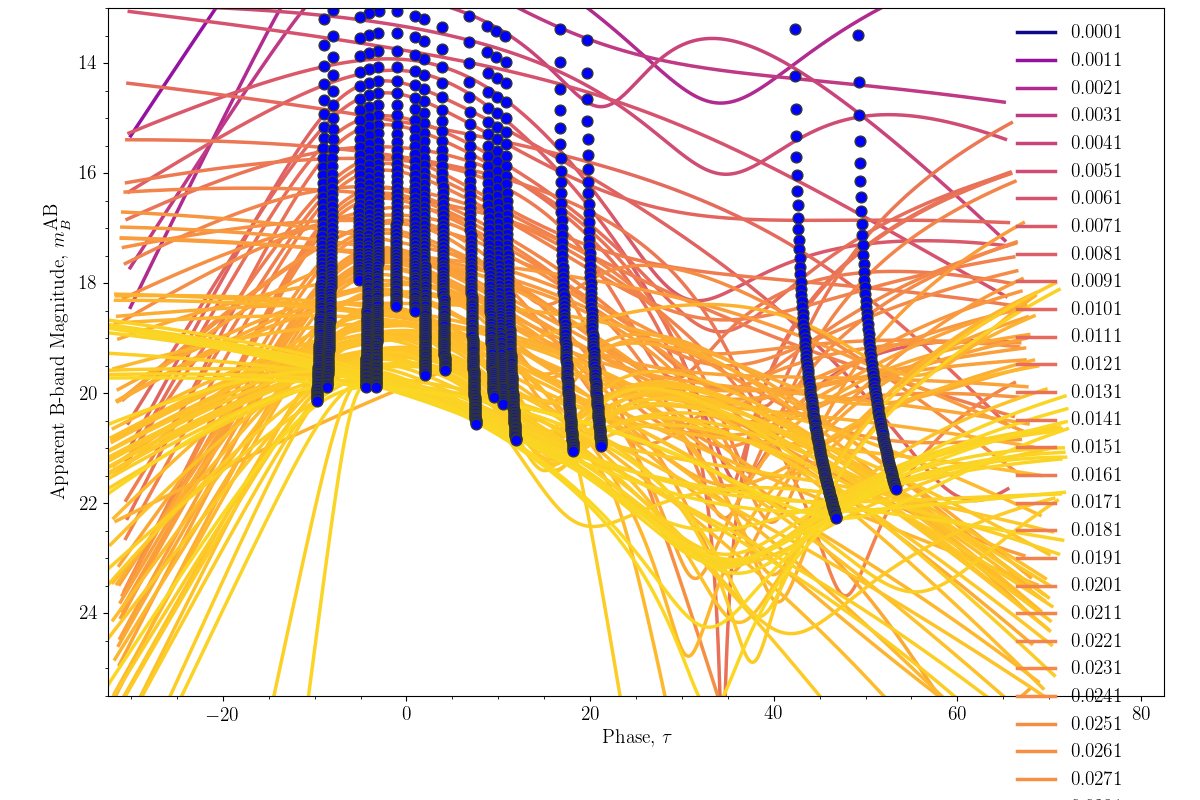

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in log10


<function matplotlib.pyplot.show>

In [129]:

fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)

mjdmax = pcc.get_mjdmax(sn, "BessellB")
mjdmax_to_sim = 0

path_to_filter = os.path.join(pcc._default_filter_dir_path,"BessellB.dat")  
BessellB = pcc.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

lcs = LCSim()

info = pcc.InfoClass()
info.load()

mjd_list = np.arange(0.,95,0.1)-30.
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    filters_to_sim = np.append(filters_to_sim, lsstt.utils.b(BessellB.filter_name))
    mjd_to_sim = np.append(mjd_to_sim, mjd)

###
colourmap = plt.get_cmap("plasma")
fig = plt.figure(figsize=[12, 8])

fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.97, hspace=0, wspace = 0)
ax1 = fig.add_subplot(111)
xaxis_label_string = r"$\textnormal{Phase, }\tau$"
yaxis_label_string = r"$\textnormal{Apparent B-band Magnitude, }m^{\textnormal{AB}}_{B}$"

z_sim = info.get_sn_info("SN1998bw")["z_distmod"]
z_list = [z_sim[0], 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
z_list = np.arange(0.0001,0.2,0.001)

log_z_list = np.log10(z_list)
z_cmap = log_z_list - np.nanmin(log_z_list)

z_cmap = z_cmap/np.nanmax(z_cmap)
for i, z_to_sim in enumerate(z_list):
    if verbose: print("running z =", z_to_sim)
    flux, flux_err = coco.simulate(b"SN1998bw",
                                   z_to_sim, 0.0, 0.0, 0.0, 3.1,
                                   mjdmax_to_sim, mjd_to_sim,
                                   filters_to_sim)
    specphot = coco.spec_photometry(b"SN1998bw", 
                 z_to_sim, b"BessellB")
    params = np.array(coco.get_fit_params())
    if i == 0:
        params_array = params
    else:
        params_array = np.vstack((params_array, params))
    params_dict[str(z_to_sim)] = params
    ###

    sn_sim = pcc.SNClass("SN1998bw")
    sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

    sp = pcc.PhotometryClass()
    sp.load_table(pcc.utils.specphot_out_to_ap_table(specphot, mjdmax_to_sim, "BessellB"))
    sp.phot["m_AB"] = -2.5 * np.log10(sp.phot["flux"]) - BessellB.zp_AB

    time_dilation = 1.+z_to_sim

    mag = -2.5 * np.log10(flux) - BessellB.zp_AB
#         ax1.scatter(sp.phot["MJD"], sp.phot["flux"])
    if i == 0:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.hex["BessellB"], 
                    label = r"$\textnormal{Bessell B}$", edgecolors = pcc.hex["batman"], 
                    s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(round(z_to_sim, 4))+"$",
                 lw=lw, zorder=0)
    else:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.hex["BessellB"],
                    label = None, edgecolors = pcc.hex["batman"], s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(z_to_sim)+"$",
                 lw=lw, zorder=0)

#         ax1.plot(mjd_to_sim, mag, color = "black", label = r"$"+str(z_to_sim)+"$")
    if verbose: print(r"$"+str(z_to_sim)+"$")
#         ax1.plot(mjd_to_sim, mag, color = colourmap(z_to_sim), label = str(z_to_sim))

#     ax1.set_ylim(np.nanmin(sp.phot["flux"]), np.nanmax(sp.phot["flux"])*yaxis_lim_multiplier)
#     ax1.set_ylim(0, 4.5e-15)
ax1.set_ylim(25.5, 13.)
ax1.set_xlim(-32.5, 82.5)

xminorLocator = MultipleLocator(xminorticks)
ax1.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(yminorticks)
ax1.yaxis.set_minor_locator(yminorLocator)

ax1.set_xlabel(xaxis_label_string)
ax1.set_ylabel(yaxis_label_string)
ax1.legend(loc = 1, scatterpoints = 1,
          numpoints = 1, frameon = False, fontsize = 14)
plt.show

In [90]:
# params_array = params_array.reshape(len(params), len(z_list))

In [136]:
params_array[:, 0]

array([  9.02433320e-01,   8.84477825e-01,   5.82761719e-02,
         9.10857199e-01,   2.31617100e-01,   1.07780690e-01,
         3.75856191e-01,   9.51073921e-02,   1.28922722e-02,
         1.75179299e-02,   6.22377728e-01,   2.48685428e-02,
         4.69317877e-02,   3.04198004e-05,   3.94209555e-03,
         3.52044933e-02,   5.99687520e-02,   9.07921633e-01,
         1.02413323e+00,   2.15939752e-01,   3.65416162e-03,
         1.38161853e-02,   5.76641985e-02,   6.68264319e-03,
         1.27607599e-01,   4.08112516e-01,   5.90884546e-01,
         3.49009703e-01,   1.76127045e-01,   9.88006686e-02,
         1.52201818e-01,   4.77308291e-02,   1.25712903e-01,
         5.78142082e-02,   2.98920149e-01,   3.61559143e-02,
         2.94574211e-01,   2.52512846e-01,   3.58279917e-01,
         1.07244875e-01,   1.22832861e-01,   7.66203207e-01,
         9.18326443e-03,   9.53719884e-01,   1.46422822e-02,
         1.10625965e-02,   3.85142146e-01,   4.64524469e-01,
         2.73172561e-01,

array([array([[1, 2, 3],
       [4, 5, 6]]), [1, 2, 3]], dtype=object)

In [143]:
def plot_params_hist(params):
    fig = plt.figure(figsize=[8, 6])

    fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                        right = 0.97, hspace=0, wspace = 0)
    ax1 = fig.add_subplot(111)
    
    hist = ax1.hist(params, bins = 20)
    
def plot_2params(params1, params2):
    fig = plt.figure(figsize=[8, 6])

    fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                        right = 0.97, hspace=0, wspace = 0)
    ax1 = fig.add_subplot(111)
    
    ax1.scatter(params1, params2)

<IPython.core.display.Javascript object>


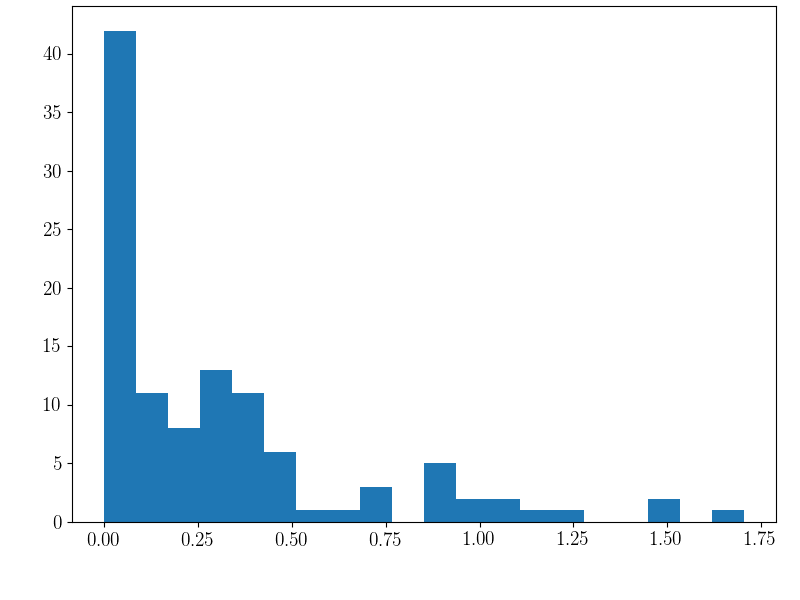

In [137]:
plot_params_hist(params_array[:, 0][np.isfinite(params_array[:, 0])])

<IPython.core.display.Javascript object>


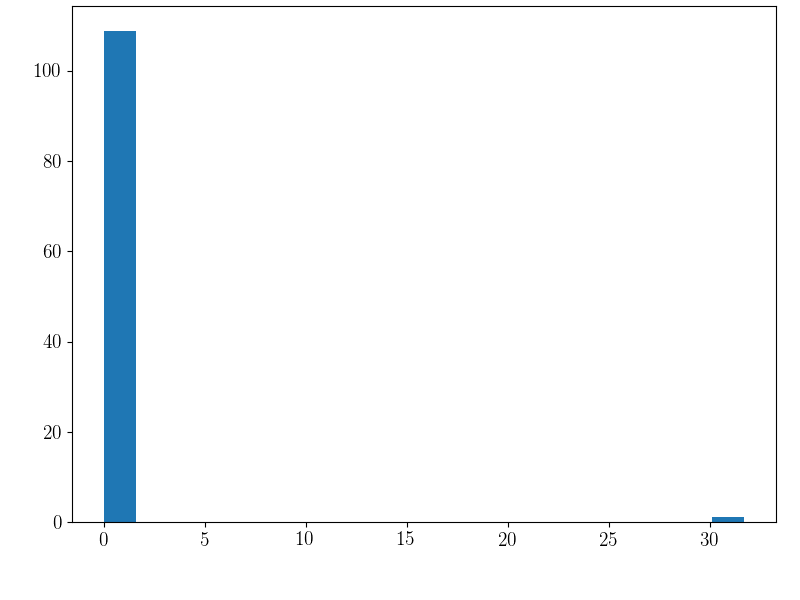

In [138]:
plot_params_hist(params_array[:,1][np.isfinite(params_array[:, 1])])

<IPython.core.display.Javascript object>


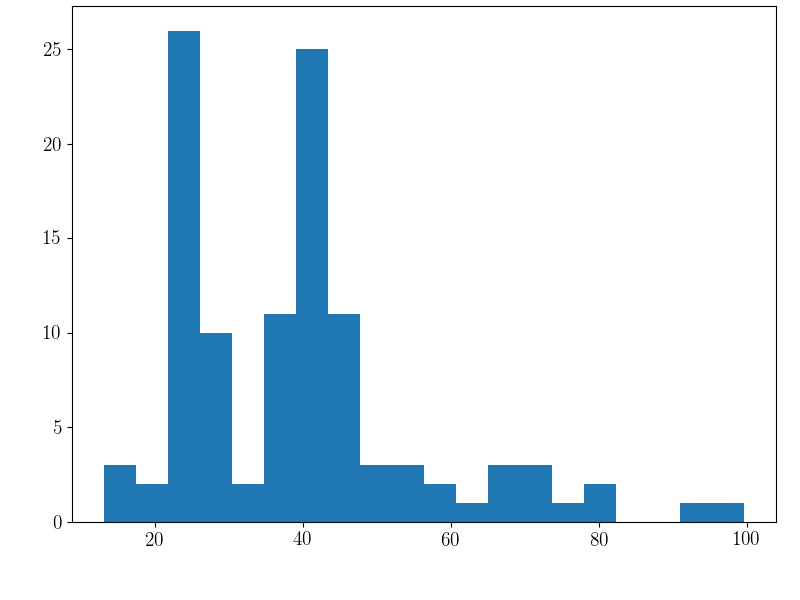

In [139]:
plot_params_hist(params_array[:,2][np.isfinite(params_array[:,2])])

<IPython.core.display.Javascript object>


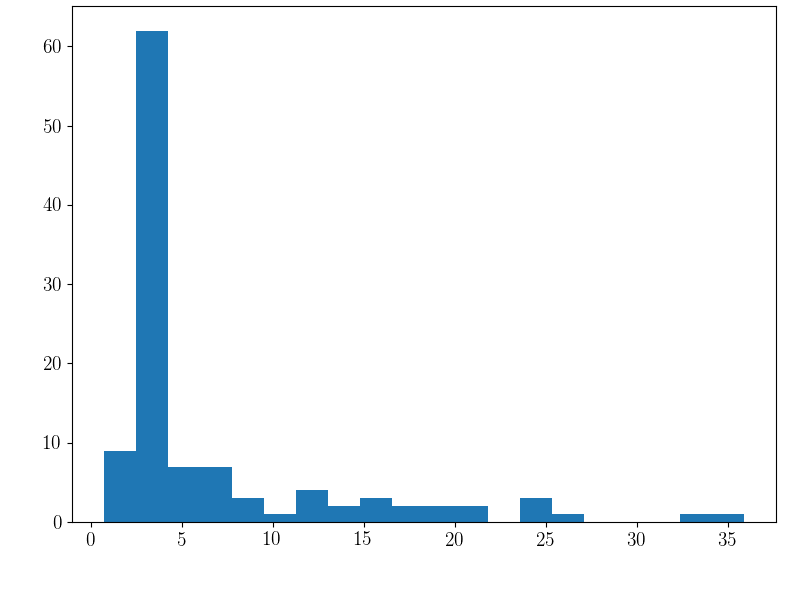

In [140]:
plot_params_hist(params_array[:,3][np.isfinite(params_array[:,3])])

<IPython.core.display.Javascript object>


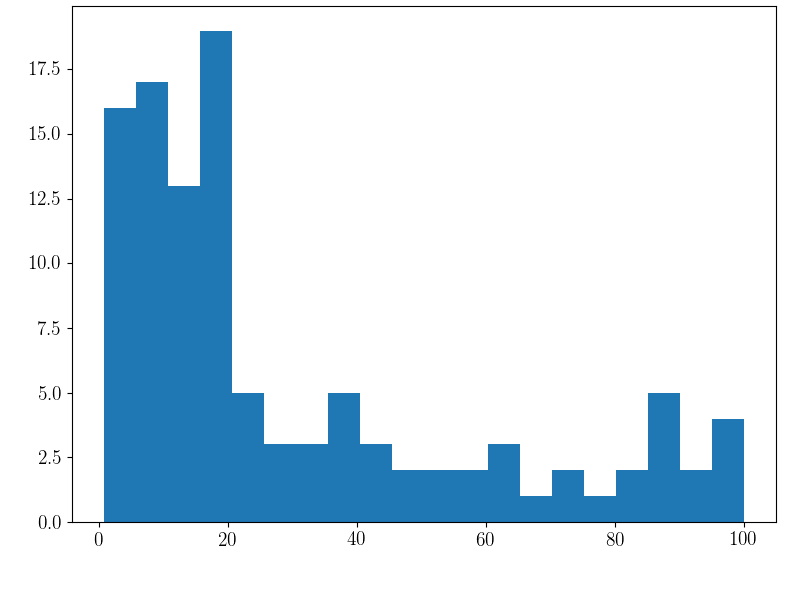

In [141]:
plot_params_hist(params_array[:,4][np.isfinite(params_array[:,4])])

<IPython.core.display.Javascript object>


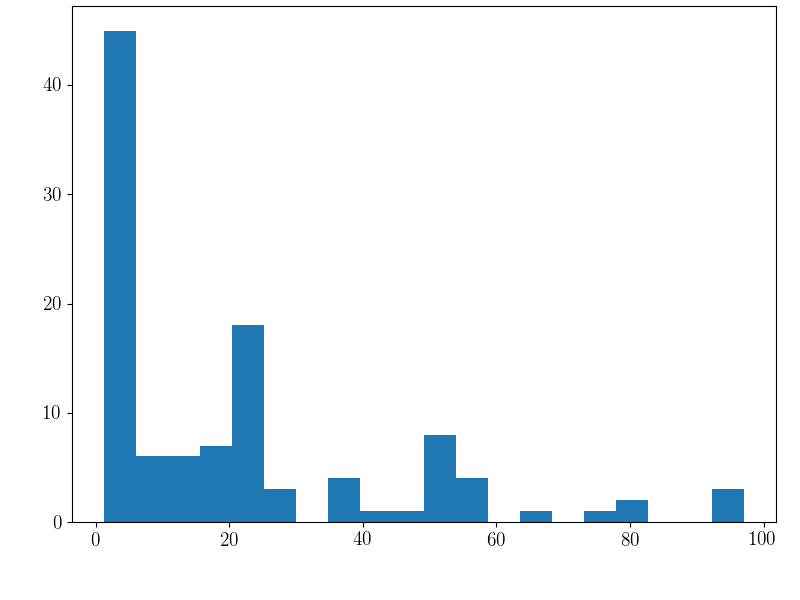

In [142]:
plot_params_hist(params_array[:,5][np.isfinite(params_array[:,5])])

<IPython.core.display.Javascript object>


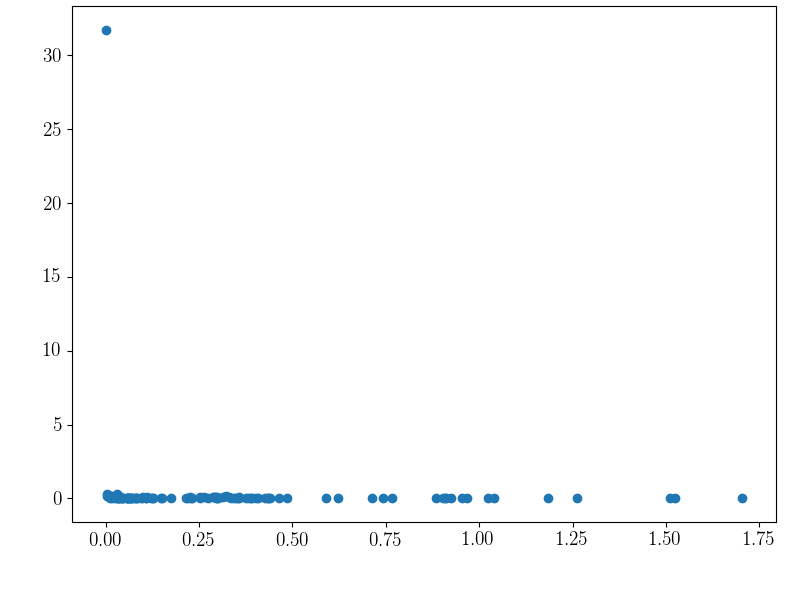

In [145]:
plot_2params(params_array[:, 0][np.isfinite(params_array[:, 0])], params_array[:, 1][np.isfinite(params_array[:, 1])])

<IPython.core.display.Javascript object>


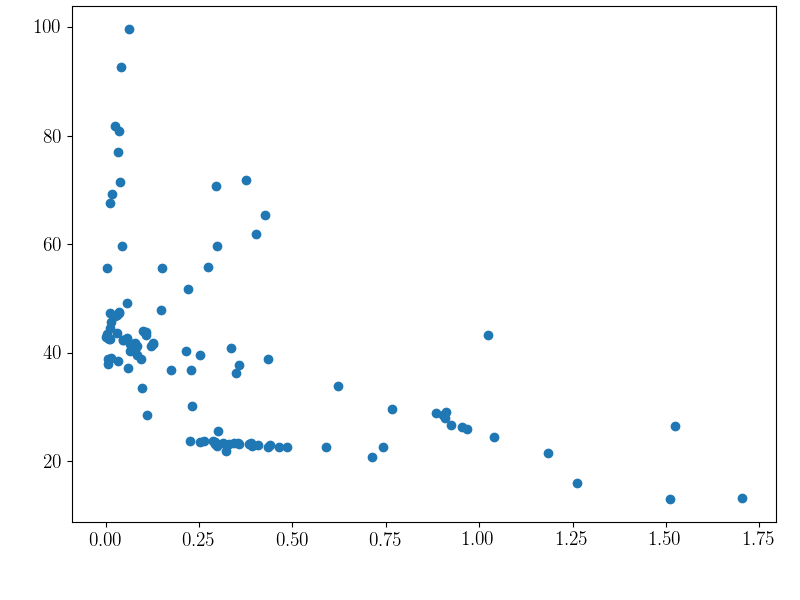

In [146]:
plot_2params(params_array[:, 0][np.isfinite(params_array[:, 0])], params_array[:, 2][np.isfinite(params_array[:, 2])])

<IPython.core.display.Javascript object>


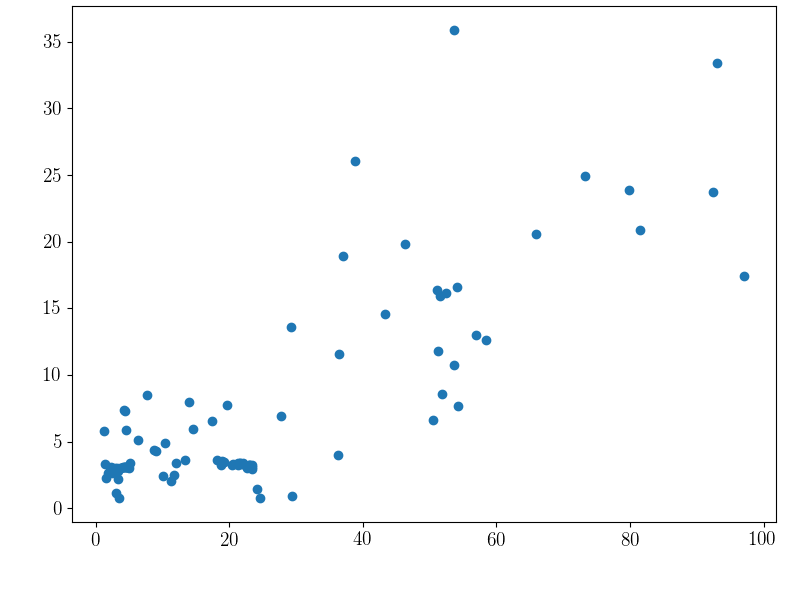

In [154]:
plot_2params(params_array[:, 5][np.isfinite(params_array[:, 5])], params_array[:, 3][np.isfinite(params_array[:, 3])])

<IPython.core.display.Javascript object>


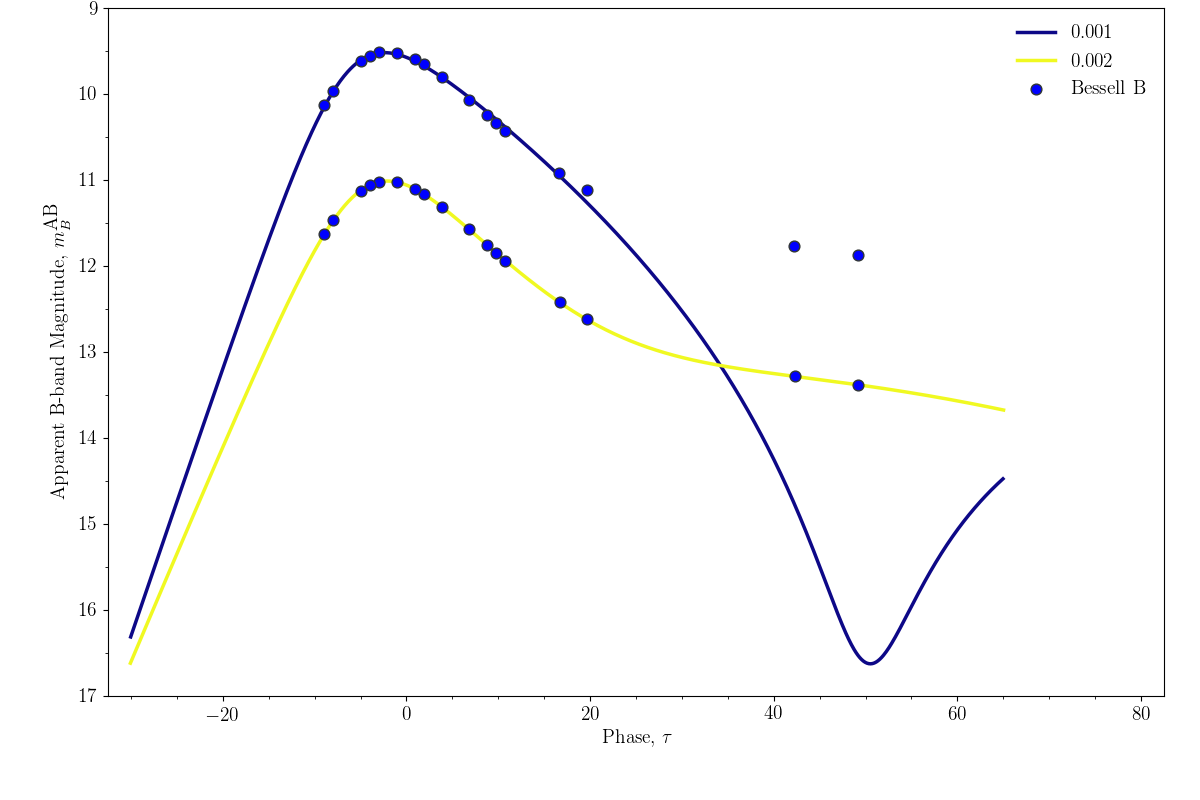

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in log10


<function matplotlib.pyplot.show>

In [161]:

fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)

mjdmax = pcc.get_mjdmax(sn, "BessellB")
mjdmax_to_sim = 0

path_to_filter = os.path.join(pcc._default_filter_dir_path,"BessellB.dat")  
BessellB = pcc.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

lcs = LCSim()

info = pcc.InfoClass()
info.load()

mjd_list = np.arange(0.,95,0.1)-30.
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    filters_to_sim = np.append(filters_to_sim, lsstt.utils.b(BessellB.filter_name))
    mjd_to_sim = np.append(mjd_to_sim, mjd)

###
colourmap = plt.get_cmap("plasma")
fig = plt.figure(figsize=[12, 8])

fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.97, hspace=0, wspace = 0)
ax1 = fig.add_subplot(111)
xaxis_label_string = r"$\textnormal{Phase, }\tau$"
yaxis_label_string = r"$\textnormal{Apparent B-band Magnitude, }m^{\textnormal{AB}}_{B}$"

z_sim = info.get_sn_info("SN1998bw")["z_distmod"]
z_list = [0.001, 0.002]
# z_list = np.arange(0.0001,0.2,0.001)

log_z_list = np.log10(z_list)
z_cmap = log_z_list - np.nanmin(log_z_list)

z_cmap = z_cmap/np.nanmax(z_cmap)
for i, z_to_sim in enumerate(z_list):
    if verbose: print("running z =", z_to_sim)
    flux, flux_err = coco.simulate(b"SN1998bw",
                                   z_to_sim, 0.0, 0.0, 0.0, 3.1,
                                   mjdmax_to_sim, mjd_to_sim,
                                   filters_to_sim)
    specphot = coco.spec_photometry(b"SN1998bw", 
                 z_to_sim, b"BessellB")
    params = np.array(coco.get_fit_params())
    if i == 0:
        params_array = params
    else:
        params_array = np.vstack((params_array, params))
    params_dict[str(z_to_sim)] = params
    ###

    sn_sim = pcc.SNClass("SN1998bw")
    sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

    sp = pcc.PhotometryClass()
    sp.load_table(pcc.utils.specphot_out_to_ap_table(specphot, mjdmax_to_sim, "BessellB"))
    sp.phot["m_AB"] = -2.5 * np.log10(sp.phot["flux"]) - BessellB.zp_AB

    time_dilation = 1.+z_to_sim

    mag = -2.5 * np.log10(flux) - BessellB.zp_AB
#         ax1.scatter(sp.phot["MJD"], sp.phot["flux"])
    if i == 0:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.hex["BessellB"], 
                    label = r"$\textnormal{Bessell B}$", edgecolors = pcc.hex["batman"], 
                    s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(round(z_to_sim, 4))+"$",
                 lw=lw, zorder=0)
    else:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.hex["BessellB"],
                    label = None, edgecolors = pcc.hex["batman"], s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(z_to_sim)+"$",
                 lw=lw, zorder=0)

#         ax1.plot(mjd_to_sim, mag, color = "black", label = r"$"+str(z_to_sim)+"$")
    if verbose: print(r"$"+str(z_to_sim)+"$")
#         ax1.plot(mjd_to_sim, mag, color = colourmap(z_to_sim), label = str(z_to_sim))

#     ax1.set_ylim(np.nanmin(sp.phot["flux"]), np.nanmax(sp.phot["flux"])*yaxis_lim_multiplier)
#     ax1.set_ylim(0, 4.5e-15)
ax1.set_ylim(17., 9.)
ax1.set_xlim(-32.5, 82.5)

xminorLocator = MultipleLocator(xminorticks)
ax1.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(yminorticks)
ax1.yaxis.set_minor_locator(yminorLocator)

ax1.set_xlabel(xaxis_label_string)
ax1.set_ylabel(yaxis_label_string)
ax1.legend(loc = 1, scatterpoints = 1,
          numpoints = 1, frameon = False, fontsize = 14)
plt.show

In [162]:
params_array

array([[  1.02353411e-02,   5.06408714e-02,   5.90536860e+01,
          2.86790717e+00,   2.87537829e+01,   2.70436646e+00,
          8.89340350e-13],
       [  8.85173557e-01,   1.84847821e-03,   2.88470547e+01,
          3.10640973e+00,   1.79341725e+01,   4.30421411e+00,
          2.22097677e-13]])

In [157]:
"A"
"B"
"t1"
"t_r"
"t_f"
"t_0"

't_0'

In [26]:
for key in params_dict:
    print(params_dict[key])

[  3.44220860e-02   3.39946221e-02   4.17028898e+01   3.31182032e+00
   4.32741247e+01   3.45426147e+00   1.40294432e-14]
[  1.22569105e-01   3.89335095e-04   9.99711672e+01   3.18559932e+01
   2.49278324e+01   6.47847926e+01   8.80425461e-15]
[  6.94479753e-02   5.98218438e-02   4.77586580e+01   1.96910204e+01
   4.18377080e+01   8.68668490e+01   2.17395235e-15]
[  4.18072303e-01   4.96664862e-02   2.28412245e+01   3.39841601e+00
   6.50226797e+00   1.98123440e+01   3.34229701e-16]
[  4.78426559e-01   1.57323327e-03   3.72792635e+01   1.27445203e+00
   2.87587152e+01   3.03653714e+00   7.69065296e-17]
[ nan  nan  nan  nan  nan  nan   0.]
[ nan  nan  nan  nan  nan  nan   0.]


In [28]:
k = [key for key in params_dict]

In [38]:
np.append([params_dict[k[0]]], [params_dict[k[1]]], axis=0).T

array([[  3.44220860e-02,   1.22569105e-01],
       [  3.39946221e-02,   3.89335095e-04],
       [  4.17028898e+01,   9.99711672e+01],
       [  3.31182032e+00,   3.18559932e+01],
       [  4.32741247e+01,   2.49278324e+01],
       [  3.45426147e+00,   6.47847926e+01],
       [  1.40294432e-14,   8.80425461e-15]])

In [ ]:
print(mjdmax)
print(snname)

In [ ]:
# snname = "SN2007uy"
snname = snname.strip("b'")
# snname = "SN1993J"


sn = pcc.SNClass(snname)

phot_path = os.path.join(pcc._default_data_dir_path, "lc/", snname + ".dat")
speclist_path = os.path.join(pcc._default_list_dir_path, snname + ".list")
recon_filename = os.path.join(pcc._default_recon_dir_path, snname + ".dat")

print(phot_path)
sn.load_phot(path = phot_path)
# sn.phot.plot()
sn.get_lcfit(recon_filename)

sn.load_list(path = speclist_path)
sn.load_spec()
# sn.load_mangledspec()
# sn.plot_spec()
# sn.plot_mangledspec()
# sn.plot_lc(multiplot = False, mark_spectra=True, savepng=True, outpath = "/Users/berto/projects/LSST/SN2007uy")
sn.plot_lc(multiplot = True, mark_spectra=True)
# sn.plot_lc(multiplot = False, mark_spectra=True)

In [ ]:
z_sim = 0.001
specphot_ap_table = Table()
# for filter_name in filter_names:
#     specphot = coco.spec_photometry(snname, 
#                      z_sim, lsstt.b(filter_name))
#     specphot_ap_table 
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("SDSS_g"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("SDSS_r"))
specphot = coco.spec_photometry(lsstt.b(snname), 
             z_sim, lsstt.b("BessellV"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("BessellR"))

In [ ]:
specphot

In [ ]:
plt.scatter(specphot[0], specphot[1])
plt.ylim(np.nanmin(specphot[1]), np.nanmax(specphot[1])*1.1)

In [ ]:
verbose = False
stepsize = 0.05
plot = True
snname=pcc.utils.b(snname)
for z_sim in np.arange(0.001, z_max+stepsize,stepsize):
    print("simulating " , snname, "at z=", z_sim)
    if log:
        logpath = logfile + str(n_sne+1).rjust(6, "0") +".json"

    # snname = b"SN2011dh"
    # mag_offset = -2.0 ## Make Ia-like
    ## Simulate "Perfect" LC
    flux, flux_err = coco.simulate(snname,
                                   z_sim, mag_offset, MW_EBV, host_EBV, 3.1,
                                   mjdmax, mjd_to_sim,
                                   filters_to_sim)
    #
    # flux, flux_err = coco.simulate(snname,
    #                                z_obs, 0.0, 0.0, 0.0, 3.1,
    #                                mjdmax, mjd_to_sim,
    #                                filters_to_sim)
#         print(flux)
    p = pcc.PhotometryClass()
    p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim), verbose=False)
    if plot: p.plot(enforce_zero=True)

    ## calculate zeropoints and convert to mag
    p_df = p.phot.to_pandas()
    p_df["zp"] = p_df["filter"].map(zp_dict)
    if verbose: print(p_df)
    p_df["mag"] = -2.5 * np.log10(p_df.flux) - p_df.zp

    ## Add noise - returns units of
#         flux, flux_err = lcs.simulate(p_df["mag"], obslog, unit="ab")
    flux = pd.Series(flux)
    flux_err = pd.Series(0.05*flux)

#     if plot:
#         plt.errorbar(p_df.MJD, flux, yerr=flux_err.values, fmt="o")
#         plt.show()

    w_detected = np.where((~np.isnan(flux.values)) & ((flux.values/flux_err.values) > 5))[0]
    # if verbose:
    if verbose:
        print("Flux, Flux_err")
        print(flux, flux_err)
    if verbose:
        print("where detected, len")
        print(w_detected, len(w_detected))


    if verbose: print("good sne")
    ## Remove redshift simulated at top of code from the list
    # z_obs = np.delete(z_obs, [w_z])

    p_df["flux"] = flux
    p_df["flux_err"] = flux_err
    p_df["#MJD"] = p_df["MJD"]
    p_df.fillna(0, inplace = True)
    full_out_path = outfile + str(z_sim).rjust(6, "0") + ".dat"
    p_df[["#MJD", "flux", "flux_err", "filter"]].to_csv(full_out_path, sep=" ", index = False, )

    if log:
        logdict = {}
        for i in logvars:
            if type(locals()[i]) == np.ndarray:
                logdict[i] = locals()[i].tolist()
            elif type(locals()[i]) == np.int64:
                logdict[i] = int(locals()[i])
            elif type(locals()[i]) == pd.Series:
                logdict[i] = locals()[i].to_json()
            elif type(locals()[i]) == bytes:
                logdict[i] = str(locals()[i], "utf-8")
            else:
                logdict[i] = locals()[i]

        with open(logpath, "w") as ofile:
            json.dumps(logdict, sort_keys=True,
                       indent=4, separators=(',', ': '))
            #     for i in logvars:
            json.dump(logdict, ofile, sort_keys=True,
                      indent=4, separators=(',', ': '))

        #         ofile.write(str(i) + " " + str(locals()[i]) + "\n")
            ofile.close()


In [ ]:
-2.5 * np.log10(p_df.flux) - p_df.zp

Load in an templates object 